<a href="https://colab.research.google.com/github/sarahdell/DSPS_SDellorco/blob/main/hw5/Dellorco__FitLineToGRBAfterGlow_mcmc_DSOS23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting a line to GRB afterglow photometry

This exercise teaches you to fit the simplest model to data: a line, using different methods.

Notes:

    a line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process
    
    we will learn later that a broken powerlaw is a prefer model for the GRB afterglow. But this exercise is about fitting lines: Linear Regression
    

# initial imports

In [1]:
import pandas as pd
import pylab as plt
import numpy as np
%pylab inline
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
from scipy.optimize import minimize
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
!pip install emcee
import emcee
!pip install corner
import corner

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.6 MB/s eta 0:00:00


# Read in the input dataset
I am reading the data with Pandas. Pandas has excellent utilities for input-output of tabular data and also for time variables. We will use it throughout as our main package to acquire and manipulate data

In [2]:
grbAG = pd.read_csv("https://raw.githubusercontent.com/fedhere/DSPS_FBianco/main/data/grb050525A.csv")
grbAG.head()

,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


In [3]:
grbAG.tail()

,filter,time,mag,magerr,upperlimit
114,W1,63738,21.20,NaN,1
115,M2,74798,21.59,NaN,1
116,U,128928,20.05,NaN,1
117,V,971360,22.09,NaN,1
118,V,1171176,21.16,NaN,1


In [4]:
grbAG.describe()

,time,mag,magerr,upperlimit
count,1.190000e+02,119.000000,108.000000,119.000000
mean,2.767789e+04,16.239282,0.188981,0.092437
std,1.391231e+05,2.506169,0.088676,0.290867
min,6.600000e+01,12.860000,0.060000,0.000000
25%,2.085000e+02,14.340842,0.120000,0.000000
50%,6.240000e+02,15.780000,0.180000,0.000000
75%,6.372500e+03,17.883091,0.230000,0.000000
max,1.171176e+06,22.090000,0.540000,1.000000


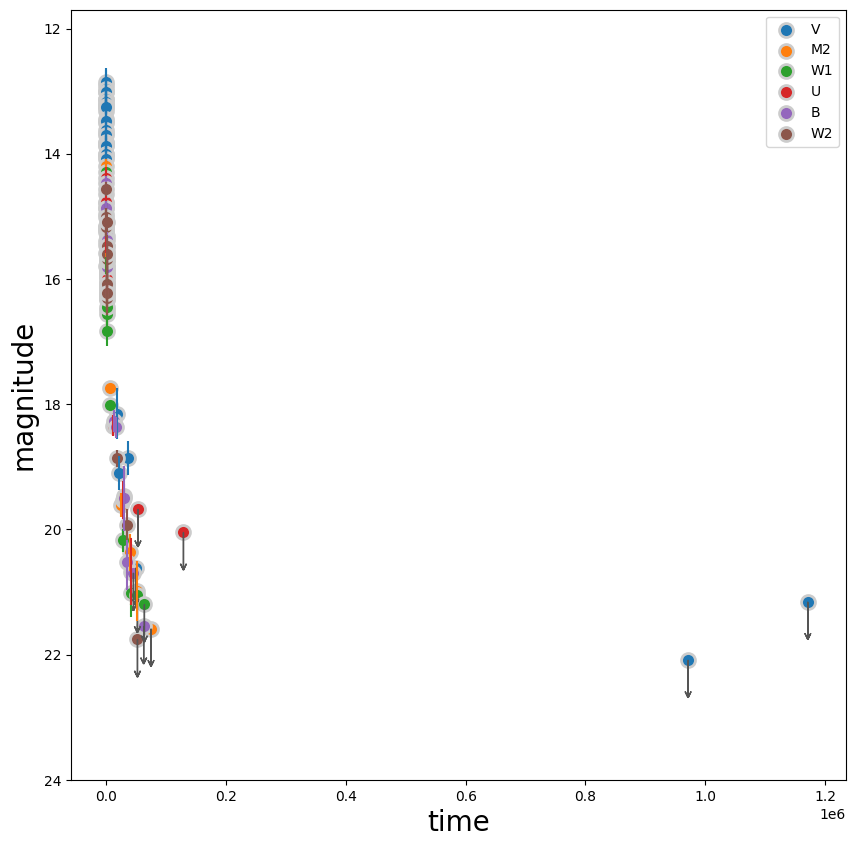

In [5]:
#create a figure container and an axis object inside of it
ax = plt.figure(figsize=(10,10)).add_subplot(111)

#loop on every filter to plot - this will give differnt colors naturally.
#Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():
    plt.errorbar(grbAG.loc[grbAG["filter"] == f, "time"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    plt.scatter(grbAG.loc[grbAG["filter"] == f, "time"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


# plot the upperlimits as arrows
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    plt.arrow(grbAG.loc[i].time,
             grbAG.loc[i].mag, 0, 0.5, head_width=1e4,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
plt.ylim(24,11.7)
plt.legend()

#Always rememebr you axis labels!!
plt.ylabel("magnitude", fontsize=20)
plt.xlabel("time", fontsize=20);

Figure 1: The plot of magnitude vs. time is shown with error arrows. The data seems to follow a general trend, with a few outliers shown on the right. The color signifies the filter used to collect that datapoint.

# Create the log-time variable

We will fit a line in log space. That corresponds to fitting a powerlaw y=x^a in natural space.


In [6]:
grbAG['logtime'] = np.log10(grbAG['time'])
grbAG.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


# Visualize the data
The data are photometric measurements: measurement of flux from an exploding star. The flux is measured in different photometric bands, i.e. within different wavelength range. You can think about this as a filter that would limit the light collected by a camera to a single color, e.g. red, blue, or green. In most all cameras (your phone camera for example) collect data in RGB bands saparately and combine them to create a "color picture". Our eyes also perceive color in 3 bands, R, G, B.

The information about the photometric band is stored in the variable ```grbAG.filter```. Plot the data with different colors for different photometric bands.

In [7]:
def plotlogtime(df, models=[]):
  #create a figure container and an axis object inside of it
  ax = plt.figure(figsize=(10,10)).add_subplot(111)

  #loop on every filter to plot - this will give differnt colors naturally.
  #Use pl.errorbar to plot the uncertainties

  for f in grbAG["filter"].unique():
    plt.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

  # replot to add a better marker (optional)
  for f in grbAG["filter"].unique():
    plt.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


  # plot the upperlimits as arrows
  nuplim = grbAG.mag.isna().sum()
  for i in grbAG[grbAG.upperlimit == 1].index:
    plt.arrow(grbAG.loc[i].logtime,
             grbAG.loc[i].mag, 0, 0.5, head_width=0.1,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

  # I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
  plt.ylim(24,11.7)
  plt.legend()

  #Always rememebr you axis labels!!
  plt.ylabel("magnitude", fontsize=20)
  plt.xlabel("log time", fontsize=20)
  return ax

<Axes: xlabel='log time', ylabel='magnitude'>

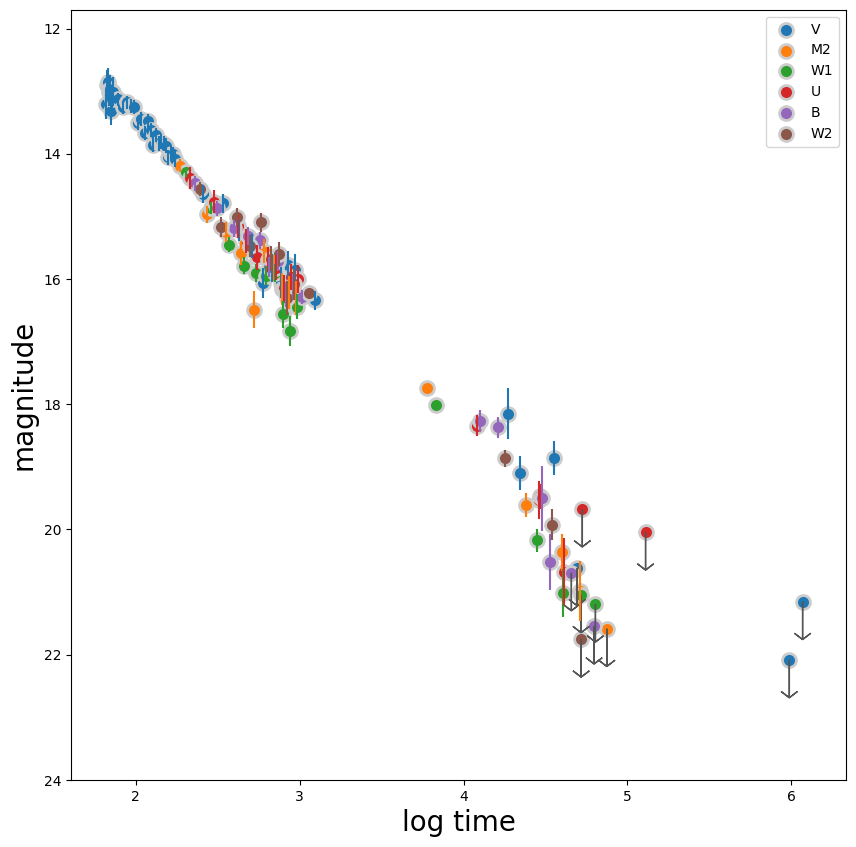

In [8]:
plotlogtime(grbAG)

Figure 2: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows.

# Solve using the Normal Equation

It can be shown that the best linear fit to data is given by the equation:  

$(X^T \cdot X)^{-1} \cdot X^T \cdot \vec{y}$

The solution is a tuple of 2 parameters: sloper and intercept. Therefore the input has to be Nx2


In [9]:
x = grbAG[grbAG.upperlimit == 0].logtime.values
X = np.c_[np.ones((len(grbAG) - grbAG.upperlimit.sum(), 1)), x]


y = grbAG.loc[grbAG.upperlimit == 0].mag.values
print("shape of the input array X", X.shape)
print("shape of the input array y", y.shape)
#note the shape in python is flipped compared to the shape in linear algebra

shape of the input array X (108, 2)
shape of the input array y (108,)


In [10]:
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print ("best fit parameters from the Normal Equation: " +
       "intercept {:.2f}, slope {:.2f}".format(*theta_best))

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


# Fit a line to the data (excluding the upper limits) with sklearn LinearRegression

The exogenous (independent) variable is ```grbAG.logtime```.

The information about whether the point is an upper limit or a measurement is stored in the variable ```grbAG.upperlimit```.
To remove the upper limits you can "broadcast" the data: in pandas that looks like

```grbAG.loc[grbAG.upperlimit == 0]```



In [11]:
grbAG = grbAG[grbAG.upperlimit==0]

In [12]:
lr.fit(X, y)
print("The best fit parameters from sklearn are intercept: {0:.2f} slope: {1:.2f}".format(lr.intercept_,lr.coef_[1]))

The best fit parameters from sklearn are intercept: 8.58 slope: 2.51


# Fit a line to the data (excluding the upper limits) by minimizing an objective function

First, choose the L1 and L2 metric (see class notes) as the objective function.

Use ```scipy.optimize.minimize()``` to minimize it.


In [13]:
#FUNCTIONS

def line(x, intercept, slope):
    """
    Calculate the y-coordinate of a point on a straight line.

    This function calculates the y-coordinate (vertical position) on a straight line
    given the x-coordinate (horizontal position), intercept (y-coordinate where the line
    crosses the y-axis), and slope (rate of change of the line).

    Args:
        x: The x-coordinate of the point.
        intercept: The y-coordinate where the line intersects the y-axis.
        slope: The rate of change of the line, representing the slope.

    Returns:
        The y-coordinate (vertical position) of the point on the line.
    """
    return slope * x + intercept


def l1(args, x, y):
    '''l1 target function: returns value of l1 for given arguments and data for a line model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the exogenous variable (array)
    returns L1 sum of absolute value of difference between prediction and data
    '''
    a, b = args
    return np.sum(np.absolute(y - line(x, a, b)))

def l2(args, x, y):
    '''l2 target function: returns value of l2 for given arguments and data for a line model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the exogenous variable (array)
    returns L2 sum of difference between prediction and data squared
    '''
    a, b = args
    return np.sum((y - line(x, a, b))**2)

def Rsquare(args, x, y):
    """
    Calculate the coefficient of determination (R-squared) for a linear regression model.

    This function computes the R-squared value for a linear regression model, which
    indicates the proportion of the variance in the dependent variable (y) that can
    be explained by the independent variable (x) using the linear model with the
    specified parameters (args).

    Args:
        args: A tuple containing the linear regression parameters (intercept and slope).
        x: The independent variable data (x-values).
        y: The dependent variable data (y-values).

    Returns:
        The R-squared value, a measure of the goodness of fit of the linear model to the data.
    """
    a, b = args
    y_pred = line(x, a, b)
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return 1 - (ss_res / ss_tot)

In [14]:
initialGuess = (10, 1)

l1Solution = minimize(l1, initialGuess, args=(x, y))
print(l1Solution)
print("")
print("best fit parameters from the minimization of L1: " +
       "intercept {:.2f}, slope {:.2f}".format(*l1Solution.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 26.303317772383874
        x: [ 8.225e+00  2.641e+00]
      nit: 17
      jac: [-1.359e-01 -2.094e+00]
 hess_inv: [[ 1.935e-04 -4.675e-05]
            [-4.675e-05  1.132e-05]]
     nfev: 391
     njev: 125

best fit parameters from the minimization of L1: intercept 8.23, slope 2.64


Text(0.5, 1.0, 'mag vs. logtime for L1')

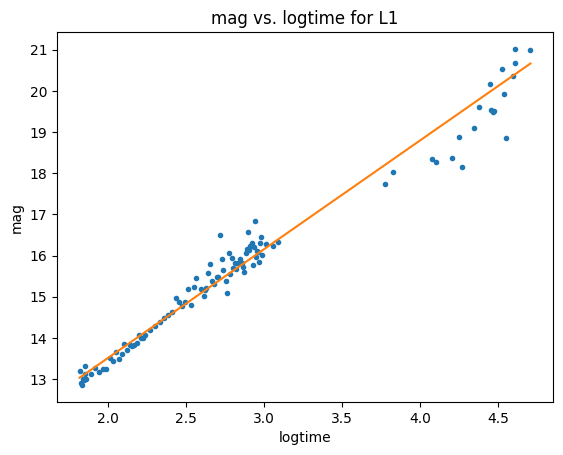

In [15]:
plt.plot(x,y, ".")
plt.plot(x, line(2.64, 8.23, x))
plt.xlabel('logtime')
plt.ylabel('mag')
plt.title('mag vs. logtime for L1')

Figure 3: Visualization of the actual data (blue) with the L1 trendline (orange) generated. The trend line appears to be a good fit for the data.

In [16]:
initialGuess = (10, 1)

l2Solution = minimize(l2, initialGuess, args=(x, y))
print(l2Solution)
print("")
print("best fit parameters from the minimization of L2: " +
       "intercept {:.2f}, slope {:.2f}".format(*l2Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 12.82598750072551
        x: [ 8.583e+00  2.512e+00]
      nit: 4
      jac: [ 0.000e+00  2.384e-07]
 hess_inv: [[ 6.254e-02 -2.030e-02]
            [-2.030e-02  7.114e-03]]
     nfev: 18
     njev: 6

best fit parameters from the minimization of L2: intercept 8.58, slope 2.51


Text(0.5, 1.0, 'mag vs. logtime for L2')

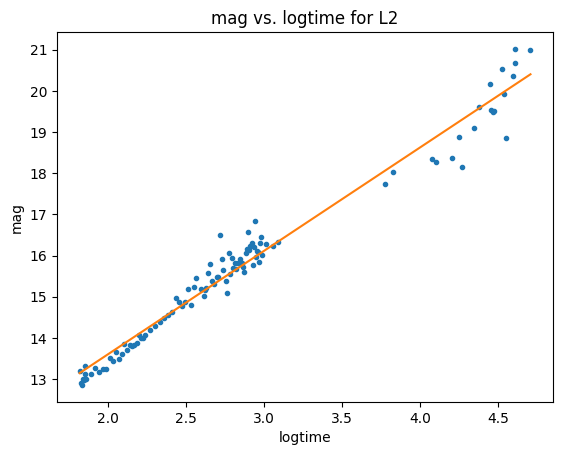

In [17]:
plt.plot(x,y, ".")
plt.plot(x, line(2.51, 8.58, x))
plt.xlabel('logtime')
plt.ylabel('mag')
plt.title('mag vs. logtime for L2')

Figure 4: Visualization of the actual data (blue) with the L2 trendline (orange) generated. The trend line appears to be a good fit for the data, although not as good as the L1 trend line.

Text(0.5, 1.0, 'mag vs. logtime')

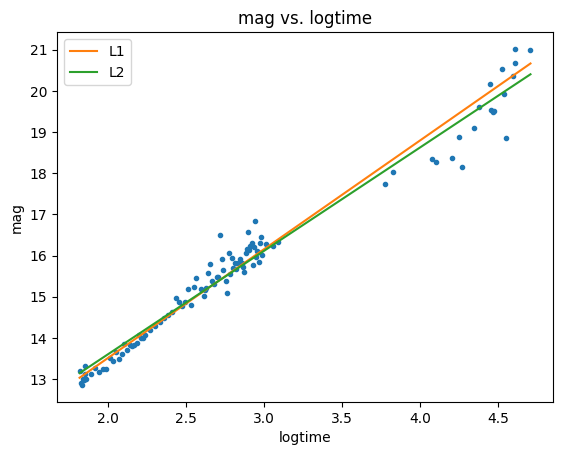

In [18]:
plt.plot(x,y, ".")
plt.plot(x, line(2.64, 8.23, x),label='L1')
plt.plot(x, line(2.51, 8.58, x),label='L2')
plt.legend()
plt.xlabel('logtime')
plt.ylabel('mag')
plt.title('mag vs. logtime')

Figure 5: The actual data (blue) plotted with both the L1 trendline (orange) and the L2 trendline (green).


# Fit a line to the data (excluding the upper limits) by minimizing an objective function that accounts for the measurements uncertainties

Since the data has uncertainty, choose the $\chi^2$ (chi squared) function as your objective function.

In [19]:
def chi2(args, x, y, s):
  '''chi squared target function: returns value of chi2 for given arguments and data for a line model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the exogenous variable (array)
    returns chi2 sum of difference between prediction and data squared divided by the error squared
    '''
  m, b = args
  return np.sum((y-line(x, m, b))**2 / s**2)

x = grbAG[grbAG.upperlimit == 0].logtime.values
y = grbAG.loc[grbAG.upperlimit == 0].mag.values
s = grbAG.loc[grbAG.upperlimit == 0].magerr.values

initialGuess = (8,2)

chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))
print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " +
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 317.4206698013056
        x: [ 8.599e+00  2.480e+00]
      nit: 7
      jac: [-1.907e-05 -1.526e-05]
 hess_inv: [[ 3.314e-03 -2.853e-03]
            [-2.853e-03  2.473e-03]]
     nfev: 125
     njev: 38

best fit parameters from the minimization of the chi squared: slope 8.60, intercept 2.48


# Plot all the solutions

Create a function that uses the parameters you input and plots a line. Add a legend that describes which line corresponds to what.


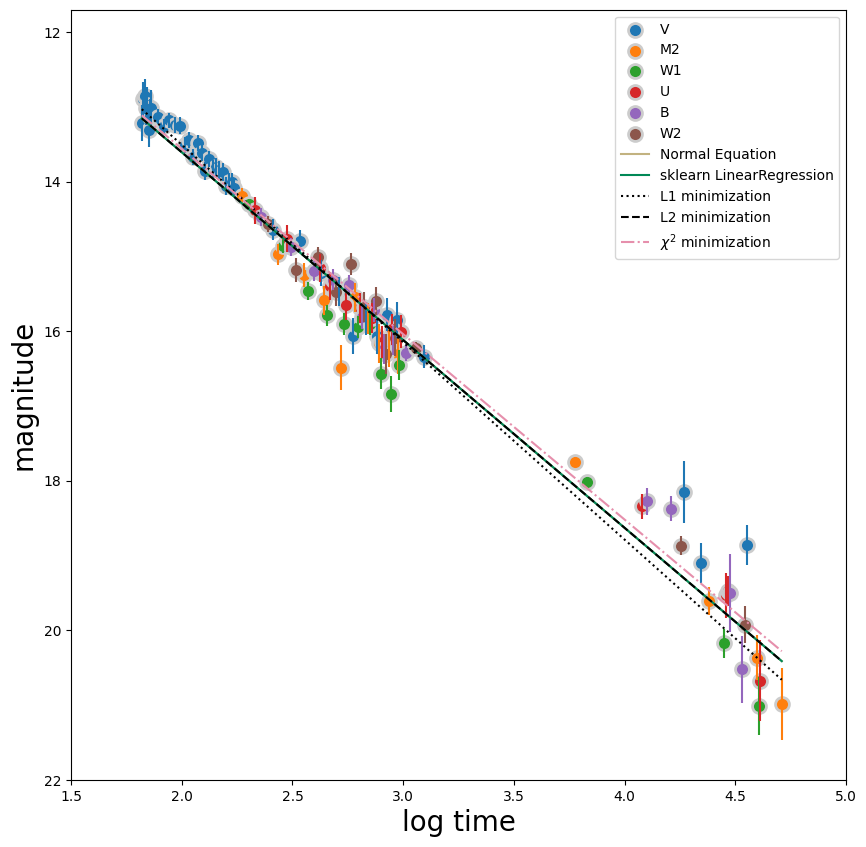

In [20]:
def plotline(pars, x, color='k', symbol='-', label='model', alpha=1, ax=ax):
    """
    Plot a line on a given axis.

    This function plots a line on a specified axis using the provided parameters.

    Args:
        pars: The line parameters (slope and intercept).
        x: The x-coordinates for the line.
        color (str, optional): The color of the line (default is 'k' for black).
        symbol (str, optional): The line style (default is '-' for a solid line).
        label (str, optional): A label for the line in the legend (default is 'model').
        alpha (float, optional): The transparency of the line (default is 1, fully opaque).
        ax (matplotlib Axes, optional): The axis on which to plot the line (default is None, current axis).

    Returns:
        None

    Note:
        This function relies on the previously defined 'line' function to calculate the y-coordinates.
    """
    slope, intercept = pars
    y = line(slope, intercept, x)
    ax.plot(x, y, ls=symbol, c=color, label=label, alpha=alpha)


ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]
#normal equation
plotline((theta_best[::-1]), grbAG.logtime.values,
         color='#'+colors[0],
         label="Normal Equation", ax=ax)

#sklearn
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)

#minimize L1
plotline((l1Solution.x[::-1]), grbAG.logtime,
         symbol=':',
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x[::-1]), grbAG.logtime,
         symbol='--',
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x[::-1]), grbAG.logtime,
         color='#'+colors[3], symbol='-.',
         label=r"$\chi^2$ minimization", ax=ax)

plt.legend()

#with the LinearRegression object I can also do
#plt.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

plt.ylim(22,11.7)
plt.xlim(1.5, 5)
plt.ylabel("magnitude", fontsize=20)
plt.xlabel("log time", fontsize=20);


Figure 6: Same as Figure 2, but with linear regression models plotted. The models correspond to the best fit line to the data (excluding upper limits) calculated analytically by solving the normal equation, by solving the fit analysitcally with sklearn.LinearRegression(), and by minimizing the objective functions L1 and Chi squared. The models are indicated in the legend.

# HW part 1: redo the sklearn model with a train-test split of the data

- choose the train-test rations that you prefer
- get the score for the model when predicting on the train data and on the test data
- what can you say about the model by comparing the two scores?

In [21]:
#Making test and training sets with 25% of the data being in the test set, and random_state being the seed for reproducibility
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

initialGuess = (10, 1)

l1Solution = minimize(l1, initialGuess, args=(x_train, y_train))

# Calculate R-squared values
train_r_squared = Rsquare(l1Solution.x, x_train, y_train)
test_r_squared = Rsquare(l1Solution.x, x_test, y_test)

print("Best fit parameters from the minimization of the L1 using training: slope {:.2f}, intercept {:.2f}".format(*l1Solution.x))
print("R-squared on training set: ", train_r_squared)
print("R-squared on test set: ", test_r_squared)

Best fit parameters from the minimization of the L1 using training: slope 8.40, intercept 2.57
R-squared on training set:  0.9705518468727363
R-squared on test set:  0.9719324378565825


In [22]:
initialGuess = (10, 1)

l2Solution = minimize(l2, initialGuess, args=(x_train, y_train))

# Calculate R-squared values
train_r_squared = Rsquare(l2Solution.x, x_train, y_train)
test_r_squared = Rsquare(l2Solution.x, x_test, y_test)

print("Best fit parameters from the minimization of the L2 using training: slope {:.2f}, intercept {:.2f}".format(*l2Solution.x))
print("R-squared on training set: ", train_r_squared)
print("R-squared on test set: ", test_r_squared)

Best fit parameters from the minimization of the L2 using training: slope 8.66, intercept 2.48
R-squared on training set:  0.9716992501494643
R-squared on test set:  0.9695582517729407


The coefficient of determination (R-squared value) must be close to 1 or -1 for the linear regression to be considered a good fit for the data. Having a result of positive 1 means the data is perfectly positively linearly coordinated, and -1 means the data is perfectly negatively linearly coordinated. For both L1 and L2, we get roughly the same result between the test and training sets for R squared. All of these values are very close to, but not exactly 1. This means the resulting linear regression line is a good fit for the data in both the L1 and L2 cases, and the two variables have a positive linear correlation.

# Now try a line to the data with MCMC

# HW part 2: write captions for each figure. The figures are produced by my code. The captions should state:
- what is plotted
- what is noticeable or interesting in the figure



look at documentation: https://emcee.readthedocs.io/en/stable/

We are implementing Bayes theorem to find the best model parameters: $P(\theta | D) ~ P(D | \theta) * P(\theta)$ or _Posterior ~ Likelihood * Prior_

Since we are maximizing the likelihood, we work in log space because:
- the logarithm is a monotonic function of its argument (meaning where the argument gets bigger its log gets bigger, where it gets smaller its log gets smaller)
- the log is not defined for negative values (log(something < 0) is undefined) but this does not matter because the likelihood is a probability and probabilities are positive defined.



In [23]:
# LINE MODEL
def log_prior(theta):
  slope, intercept = theta
  if slope > 0 and intercept > 0:
    return 0
  #semi informative prior: i know light has to get fainter (mag get bigger)
  #i know i dont use negative mags
  return -np.inf


In [24]:
#log likelihood
def log_likelihood(theta, x, y, yerr):
  slope, intercept = theta
  #chi2 likelihood : (data-model)**2 / uncertainty **2
  return -np.sum(((y - line(intercept, slope, x))**2) / yerr**2)

In [25]:
#log posterior
def log_posterior(theta, x, y, yerr):
  lp = log_prior(theta)
  if not np.isfinite(lp):
    return -np.inf
  # posterior ~ likelihood * prior => log_posterior ~ log_likelihood + log_prior
  return lp + log_likelihood(theta, x, y, yerr)

In [26]:
#initial guess
ig = [1,10]

In [27]:
#initialize N walkers
nwalkers = 32
ndim = len(ig)

In [28]:
pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim) #the starting point for each walker is a small perturbation of the initial guess

In [29]:
pos.shape

(32, 2)

In [30]:
# this sets up the model and assignes the hyperparameters
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y, s))

In [31]:
# this runs the MCMC for 5,000 steps
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:17<00:00, 283.26it/s]


In [32]:
# this extracts the ergodic markovian chains of positions in the feature space
samples = sampler.get_chain()

In [33]:
samples.shape

(5000, 32, 2)

In [34]:
# to get statistical properties of the chains I will concatenate the 32 chains. This works _iff_ the chains are independent
# note: the chains are _assumed_ to be independent
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

In [35]:
#the result of the mcmc (the best parameters and their uncertainties) are statistical properties of the chains
# I recommand the median and percentiles over the mean and standard deviation, since the chains need not be gaussian
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
  mcmc[i] = np.percentile( flat_samples[:,i], [16, 50, 84])
mcmc

array([[8.55952121, 8.59875946, 8.63789427],
       [2.46647659, 2.48035571, 2.49461729]])

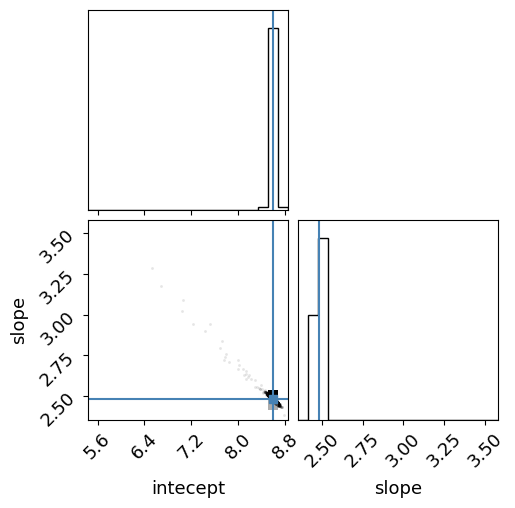

In [36]:
#plotting the likelihood space: the panels are 2D projections of the feature space and 1D marginalized probabilities for each parameters
plt.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["intecept", "slope"], truths=mcmc[:,1]);


Figure 7: This plot shows the posterior distributions and correlations between the "intecept" and "slope" parameters. The blue lines show the true values of the slope and intercept as found by the MCMC sampler. The contour/scatter plot in the corner graph shows the relationship between slope and intercept, and you can see they have a correlation since most of the values are along a diagonal, meaning they are negatively linearly correlated. As the intercept increases, the slope decreases. The outside two graphs show a histogram distribution of the slope and intercept values. They are both bell-shaped distributions.

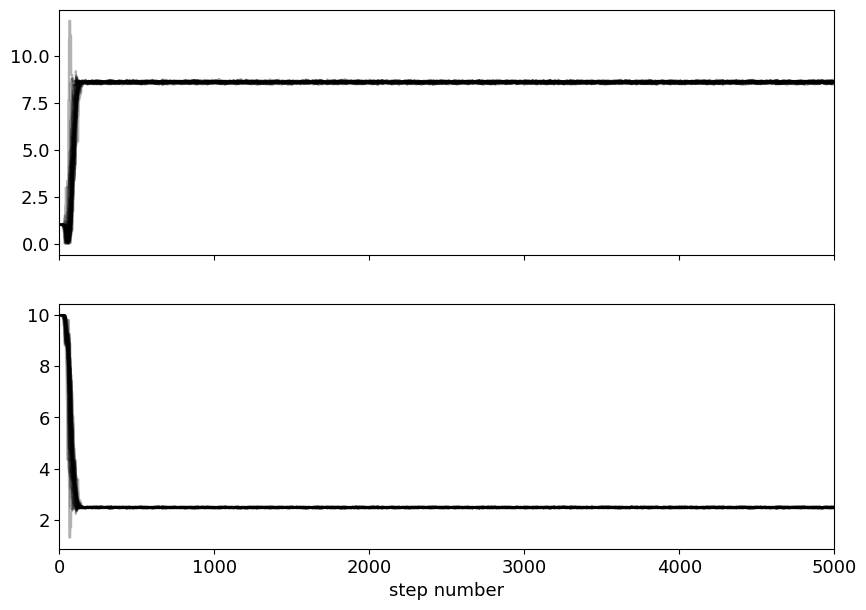

In [37]:
# the chains should be plotted as well. in the slides and in class I discuss what you should expect them to look like
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Figure 8: The top graph is for the intercept and the bottom graph is for the slope. It loops for each parameter and each of the walkers. Each walker starts at the initial guess specified earlier, and as the step number increases, they eventually converge to the true value found using the MCMC method. The x-axis represents the step number within the sampler, and the y-value represents the initial value of the walker at each step. This way, the whole dataset is explored.

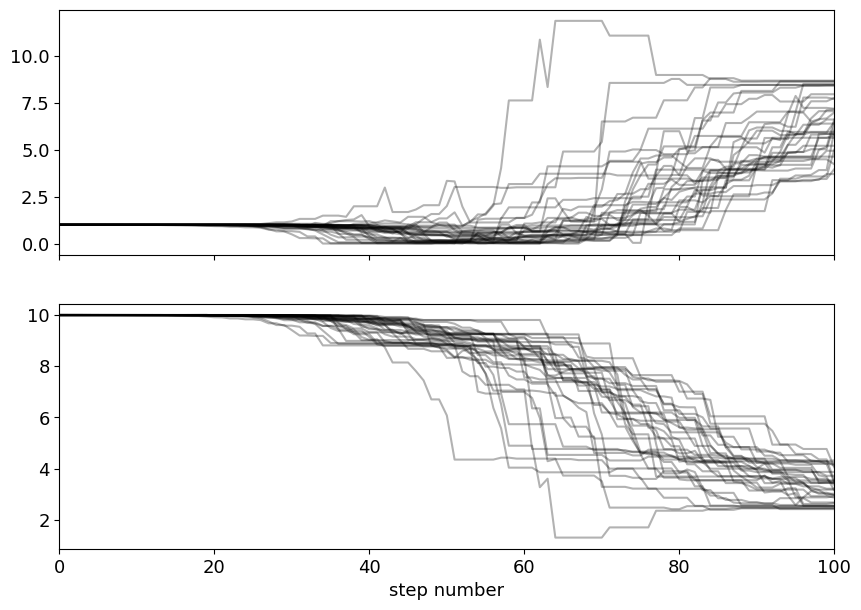

In [38]:
# zoom in: the beginning of the chain should be cut - this is the burn-in part of the chain
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, 100)#len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Figure 9: This is a zoomed-in version of the previous figure, only showing the first 100 steps as opposed to all 5000 specified. This time the top graph represents the slope and the bottom one represents the intercept. All the walkers begin at the value specified by the initial guess, but as the step number increases, they all have different initial values per step, and eventually start to converge towards the true value found using MCMC.

In [39]:
# save the mcmc results for later
mcmc_line = mcmc

# HW part 3

# Now try a broken power law (BPL) model

A power law is not a good model for GRB afterglows. A broken power law has been known to be a better model and has several physical motivations. In this exercise you will fit a _broken power law_ to the data, which is a more complex and higher dimensional model than the simple line fit we did so far, with MCMC getting best values for the posterior, a complete characterization of the likelihood, and allowing model selection between the line and the power law.

> Here is some info that talks about the power law model and the phsyics of GRB, which you need not know to solve the assignment but you may be interested in.  A broken power law is a power law ($y ~ x^a$) where the power a changes at some point. This can be caused by the presence of two power law processes with different, for example, where one dominates at early time and the other at late times.


>> Here is some more info that explains why we observed the GRB afterglows as broken power laws.
>>Gamma-ray bursts (GRBs) are produced by the collapse of massive stars or the merger of compact objects like neutron stars. The energy of the collapse is highly energetic (Gamma rays) but the emission gets reprocessed as it leaves the system and looses energy becoming detectable in the optical wavelengths. This is called the "optical afterglow of the GRB".
>>The explosion resulting from the collapse generates a highly relativistic outflow of material that moves at a significant fraction of the speed of light.
>> The afterglow emission is primarily produced through synchrotron radiation, where charged particles spiral around magnetic field lines. The radiation produced by synchrotrone follows a power law with an index that depends on the density of the surrounding medium, the Lorentz factor of the outflow, and the magnetic field strength. As the radiation crosses different regions of the system that collapsed these factors change and the powerlaw index changes with them.

>>If the relativistic outflow is highly collimated (a jet) as the jet expands, its emission can be modeled as a power-law light curve, but  where the jet begins to decelerate and spread out the slope of the power law changes. This transition is known as the "jet break" and results in a broken power-law behavior.

>> Some GRBs exhibit late-time flares or additional energy injection from the central engine but we are not modeling this in this exercise.




_BPL model variables:_

$F = \mathrm{flux}$ - note: not magnitude this time! $mag ∝ -2.5log10(Flux)$

$t =  \mathrm{time}$ - note: not log time

_BPL model parameters:_


$T_b =  \mathrm{Time~of~break}$

$a_1:  \mathrm{Early~slope}$

$a_2: \mathrm{Late~slope}$

$b:  \mathrm{nuisance~parameters}$

_BPL model_:

$F=\frac{F_0}{ \frac{t}{T_b}^{-a1} + \frac{t}{T_b}^{-a2}}$


$mag=b - log_{10}((\frac{t}{T_b})^{-a1} + (\frac{t}{T_b})^{-a2}) $



In [40]:
t = grbAG[grbAG.upperlimit == 0].time.values

In [41]:
t.min(), t.max()

(66, 51257)

# HW part 3 task 1:
create the model `bpl()`, the `log_likelihood()`, `log_prior()` (choose what you want to set your prior to), and `log_posterior()`

In [42]:
def bpl(theta, t):
    """
    Broken power law model
    Input:
      theta: (array-like) 4 parameters vector [b, Tb, a1, a2], where
             b: Nuisance parameters
             Tb: Time of break
             a1: Early slope
             a2: Late slope
      t: (array-like) Independent time variable
    Return:
      Model predictions for each t (array-like)
    """
    b, Tb, a1, a2 = theta
    mag = b - np.log10(((t / Tb)** -a1) + (t / Tb)** -a2)
    return mag


In [100]:
def log_likelihood_bpl(theta, x, y, yerr):
    """
    Log likelihood function for the broken power law model.

    Input:
      theta: (array-like) 4 parameters vector [b, Tb, a1, a2], where
             b: Nuisance parameters
             Tb: Time of break
             a1: Early slope
             a2: Late slope
      x: (array-like) Independent variable
      y: (array-like) Observed data
      yerr: (array-like) Uncertainties in the observed data

    Return:
      Log likelihood value for the given parameters, given the data and uncertainties.
    """
    b, Tb, a1, a2 = theta
    return np.sum(((y - bpl(theta, x))**2) / yerr**2)
    # use the same log_likelihood as before (chi2) but with the new model

In [101]:
def log_prior_bpl(theta):
  """
    Log prior function for the broken power law model.

    Input:
      theta: (array-like) 4 parameters vector [b, Tb, a1, a2], where
             b: Nuisance parameters
             Tb: Time of break
             a1: Early slope
             a2: Late slope

    Return:
      The logarithm of the prior probability for the given parameter values.
      Returns 0 if all parameters are positive, -np.inf if any parameter is non-positive.
  """
  b, Tb, a1, a2 = theta
  if -10000 < b < 10000 and 0 < Tb < 100000 and -10 < a1 < 10 and -10 < a2 < 10:
    return 0
  return -np.inf
#In this context, flux represents the amount of light or radiation received from an astronomical source, and it is typically a non-negative quantity.
#Negative flux values don't have physical meaning in this context, as they would imply a negative amount of light or radiation, which is not possible.
#This is why we make F0 positive, and the time and slope values must be positive as well.

In [102]:
def log_posterior_bpl(theta, x, y, yerr):
  """
    Log posterior probability function for the broken power law model.

    Input:
      theta: (array-like) 4 parameters vector [b, Tb, a1, a2], where
             b: Nuisance parameters
             Tb: Time of break
             a1: Early slope
             a2: Late slope
      x: (array-like) Independent variable
      y: (array-like) Observed data
      yerr: (array-like) Uncertainties in the observed data

    Return:
      The logarithm of the posterior probability for the given parameter values.
      Combines the log likelihood and log prior using Bayes' theorem.
      Returns -np.inf if the prior is non-finite (non-positive parameter values).
  """
  lpb = log_prior_bpl(theta)
  if not np.isfinite(lpb):
    return -np.inf
  # posterior ~ likelihood * prior => log_posterior ~ log_likelihood + log_prior
  return lpb - log_likelihood_bpl(theta, x, y, yerr)

def neg_log_likelihood_bpl(theta, x, y, yerr):
    """
    Calculate the negative log-likelihood of the broken power law (BPL) model given the model parameters.

    Parameters:
    theta (array-like): Model parameters [b, Tb, a1, a2].
    x (array-like): Independent variable values.
    y_obs (array-like): Observed data values.
    y_err (array-like): Uncertainties (errors) in the observed data.

    Returns:
    float: The negative log-likelihood of the BPL model given the data and model parameters.
    """
    return -log_likelihood_bpl(theta, x, y, yerr)

# HW part 3 task 2:
Find the initial starting point as a stochastic gradient descent minimization of the log likelihood

In [105]:
ig = [0.2, 1000, 5, 20]
#what does the minimize function need to take as arguments?
bounds = [(66, 51257), (-10, 10), (-10, 10), (-1000, 1000)]
soln = minimize(log_likelihood_bpl, ig, args=(t, y, s))
#soln = minimize(log_likelihood_bpl, ig, args=(t, y, s))
soln
print(soln)
print("")
print("best fit parameters from the minimization of the theta: " +
       "b {:.2f}, Tb {:.2f}, a1 {:.2f}, a2 {:.2f}".format(*soln.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 217.4653145657361
        x: [ 1.505e+01  2.736e+02  3.548e+00  2.146e+00]
      nit: 83
      jac: [ 2.480e-05  1.335e-05  5.913e-05  1.526e-05]
 hess_inv: [[ 1.852e-04  8.422e-04  4.152e-04 -1.839e-04]
            [ 8.422e-04  1.246e-02  5.844e-03 -1.380e-03]
            [ 4.152e-04  5.844e-03  2.751e-03 -6.926e-04]
            [-1.839e-04 -1.380e-03 -6.926e-04  3.561e-04]]
     nfev: 535
     njev: 107

best fit parameters from the minimization of the theta: b 15.05, Tb 273.59, a1 3.55, a2 2.15


Text(0.5, 1.0, 'mag vs. Time')

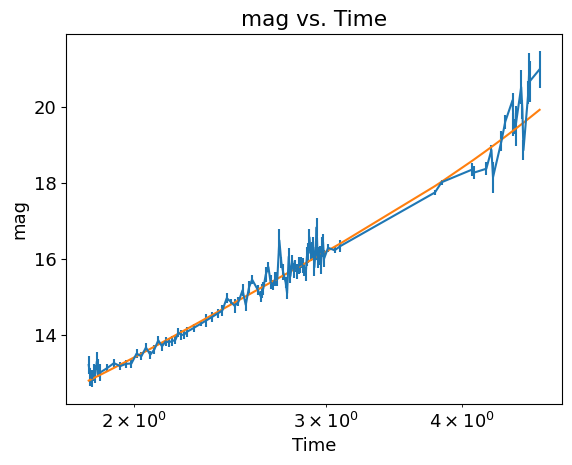

In [106]:
ig = soln.x  # The initial guess for the MCMC

# Plot the model as it looks with the initial guess values
plt.errorbar(x, y, yerr=s)
plt.plot(x, bpl(ig, t))
plt.xscale("log")
plt.xlabel("Time")
plt.ylabel("mag")
plt.title("mag vs. Time")


Figure 10: This plots the actual data (blue) as well as the broken power law fit (orange) generated using MCMC. The fit generated appears to be a good fit for the data.

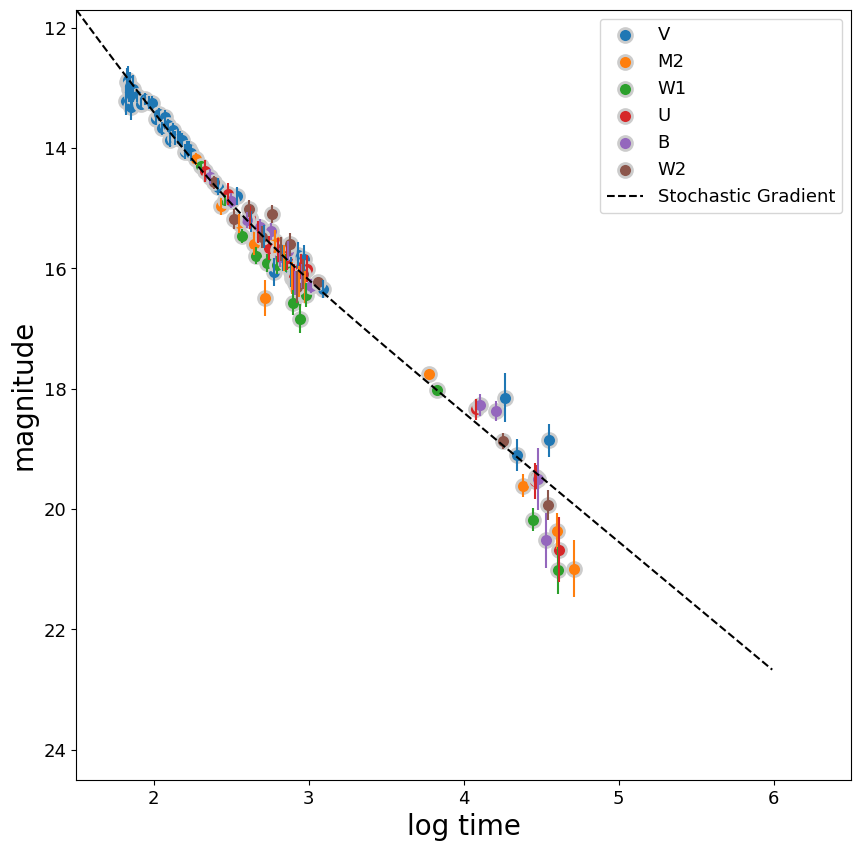

In [107]:
labels = ["intercept","slope"]
ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]
ax.plot(np.arange(1.5,6,0.01),
        bpl(ig, 10**np.arange(1.5,6,0.01)), ls="--", c="k",
        label="Stochastic Gradient")

plt.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

plt.ylim(24.5,11.7)
plt.xlim(1.5, 6.5)
plt.ylabel("magnitude", fontsize=20)
plt.xlabel("log time", fontsize=20);

Figure 11: The actual data organized by type plotted with the best fit line generated. This is basically a fancier version of the previous figure with the changes of an inverted y axis, and changing time to log time on the x-axis. You can see that the fit line generated still appears to be a good fit for the data.

# HW 3 task 3: optimize the model wit MCMC

- set the emcee hyperparameters
- run the chains
- extract the statistical properties of the chain as the best fit values
- plot the model
- plot the marginalized posteriors of the model parameters

In [108]:
# set the emcee hyperparameters
nwalkers = 30
ndim = len(ig)
pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_bpl, args=(t, y, s))

In [109]:
# run the model
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:08<00:00, 559.73it/s]


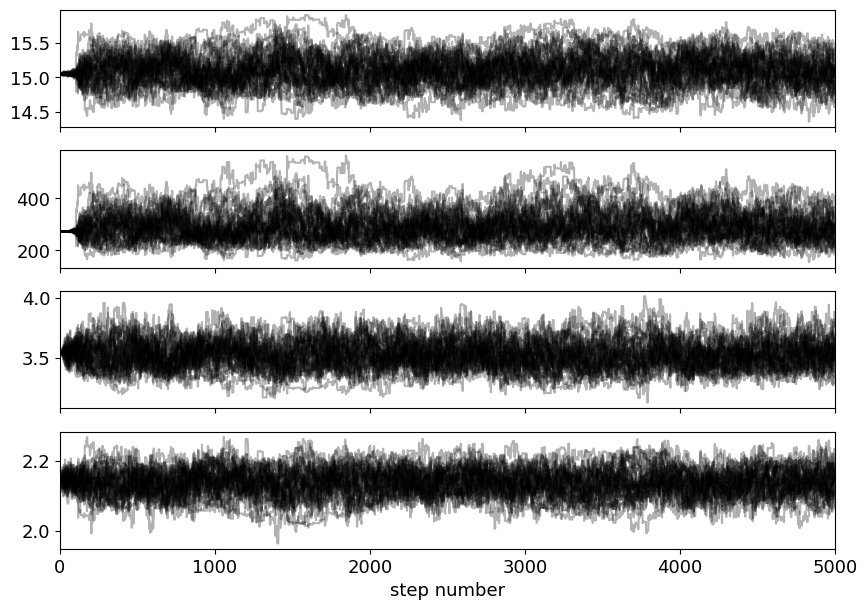

In [110]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Figure 12: This shows the path each walker took for each step number 1-5000. You can see that this data is very noisy and it does not converge to a value like the linear model did. The top graph represents the parameter b, the second graph is Tb, the third graph is a1, and the bottom graph is a2.

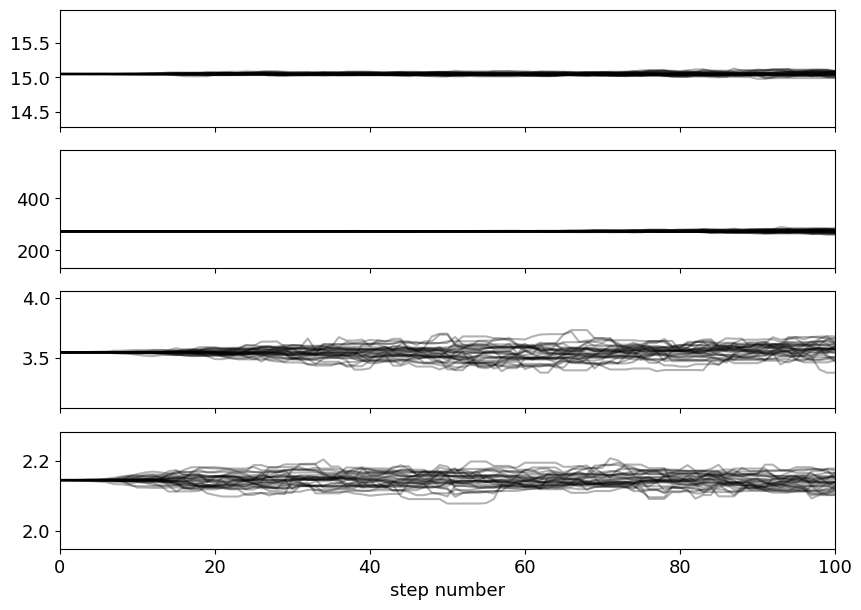

In [111]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, 100)#len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Figure 13: This plot shows the first 100 steps as opposed to all 5000 steps. The walkers start from relatively the same value, with very small perturbations. The order of the parameters represented in the graphs from top to bottom is b, Tb, a1, and a2.

In [112]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

In [113]:
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
  mcmc[i] = np.percentile( flat_samples[:,i], [16, 50, 84])
mcmc

array([[ 14.86834883,  15.09555905,  15.33872187],
       [236.42731857, 284.906471  , 349.11615392],
       [  3.40750915,   3.5226422 ,   3.64771741],
       [  2.09807275,   2.13860368,   2.17842037]])

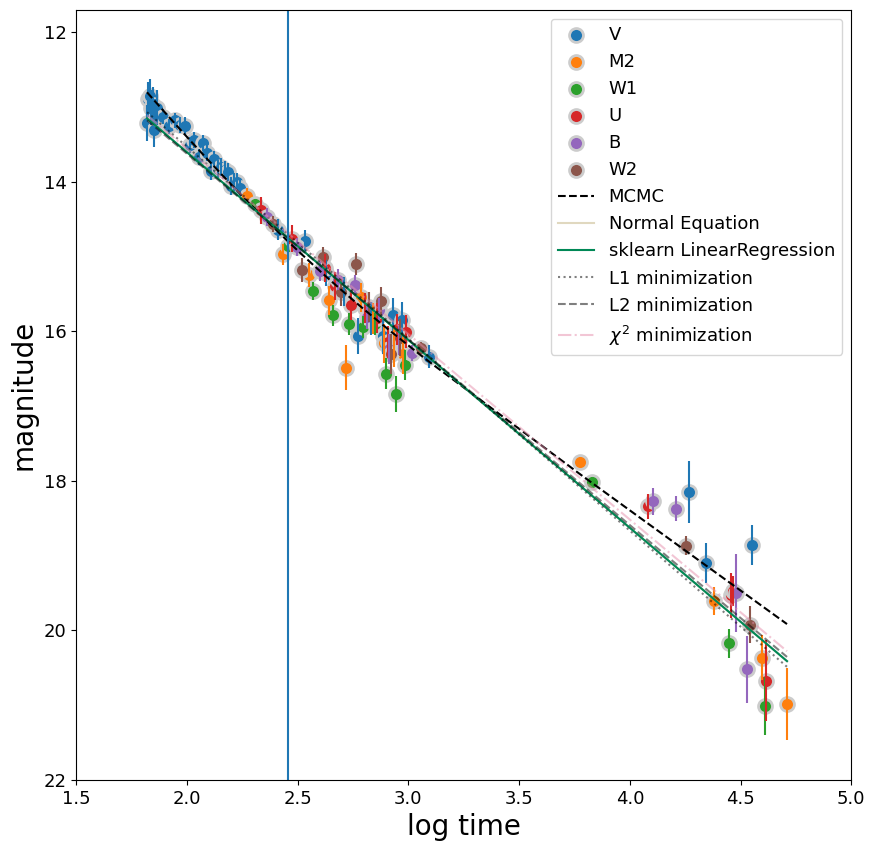

In [114]:
#plot the model
ax = plotlogtime(grbAG)

#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

ax.plot(grbAG.logtime.values, bpl(mcmc[:,1],
                            grbAG.time.values), ls="--", c="k", label="MCMC")
#normal equation
plotline((theta_best[::-1]), grbAG.logtime.values,
         color='#'+colors[0],  alpha=0.5,
         label="Normal Equation", ax=ax)
#sklearn
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)
#minimize L1
plotline((l1Solution.x[::-1]), grbAG.logtime,
         symbol=':', alpha=0.5,
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x[::-1]), grbAG.logtime,
         symbol='--', alpha=0.5,
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x[::-1]), grbAG.logtime,
         color='#'+colors[3], symbol='-.', alpha=0.5,
         label=r"$\chi^2$ minimization", ax=ax)

plt.legend()

#with the LinearRegression object I can also do
#plt.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')
plt.axvline(np.log10(mcmc[1,1]))
plt.ylim(22,11.7)
plt.xlim(1.5, 5)
plt.ylabel("magnitude", fontsize=20)
plt.xlabel("log time", fontsize=20);

Figure 14: This shows the original data and all of the fit lines we have calculated. The new fit not shown in previous graphs is the bpl MCMC fit. It appears to be a good fit for the data, but the ends tend to diverge a bit from the linear fit models.

In [115]:
mcmc

array([[ 14.86834883,  15.09555905,  15.33872187],
       [236.42731857, 284.906471  , 349.11615392],
       [  3.40750915,   3.5226422 ,   3.64771741],
       [  2.09807275,   2.13860368,   2.17842037]])

## plot the marginalized posterior distributions of the parameters

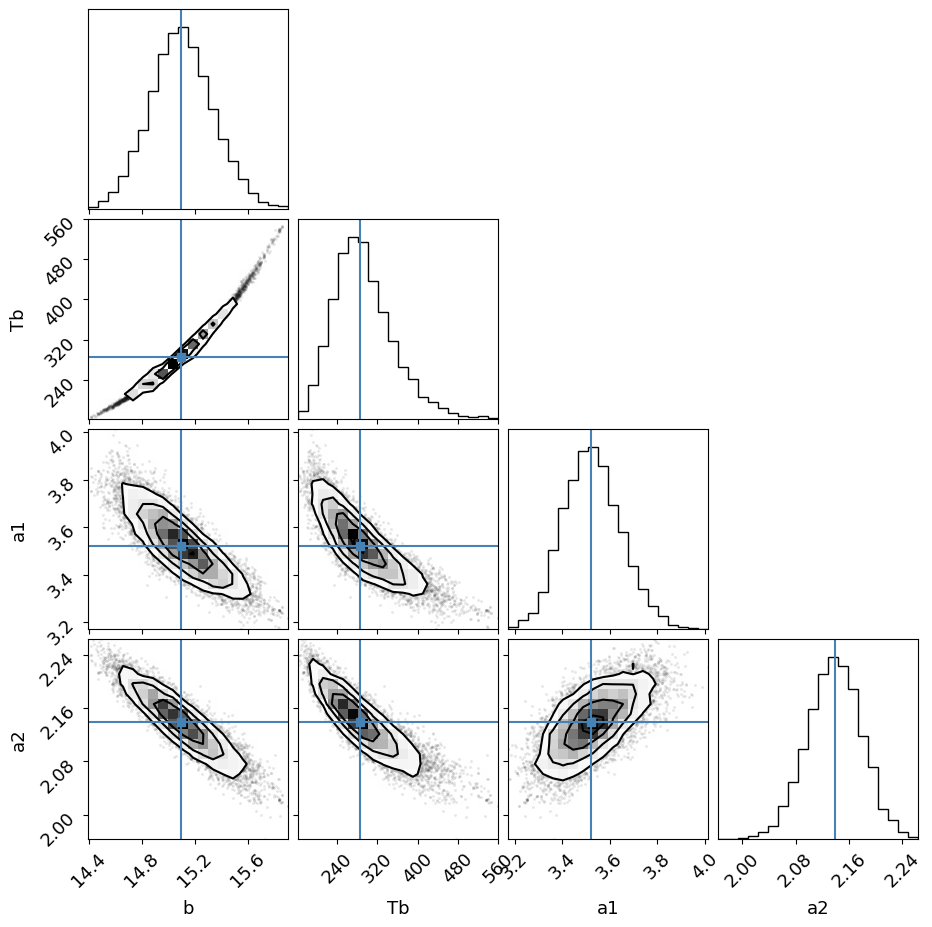

In [116]:

plt.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["b", "Tb", "a1", "a2"], truths=mcmc[:,1]);

Figure 15: This plot shows the posterior distributions and correlations between the b, Tb, a1, and a2 parameters. The blue lines show the true values of the parameters as found by the MCMC sampler. The contour/scatter plot in the corner graph shows the relationship between respective parameters, and you can see they have a correlation since most of the values are along a diagonal, meaning they are linearly correlated. The outside graphs show a histogram distribution of the various parameters values. They are all bell-shaped distributions.

# HW part 4: Compare the line (as obtained by the MCMC) and broken power law models. For this part of the assignment use the slides in part 2.2 of the current slide deck (slide column 8) https://slides.com/federicabianco/dsps_6#/8. in particular:

- Print the loglikelihood of each model (you can use the log_likelihood function you had written for each)
https://slides.com/federicabianco/dsps_6#/8/1 through https://slides.com/federicabianco/dsps_6#/8/3

- implement the caluculation of the AIC (https://slides.com/federicabianco/dsps_6#/8/4 through 6)
- and BIC (https://slides.com/federicabianco/dsps_6#/8/7)



In [117]:
print(f"The log likelihood of the Linear Model is: {log_likelihood(mcmc_line[:, 1], x, y, s):.3f}")
print(f"The log likelihood of the BPL Model is: {log_likelihood_bpl(mcmc[:,1], t, y, s):.3f}")

The log likelihood of the Linear Model is: -317.421
The log likelihood of the BPL Model is: 217.490


## Implement the likelihood ration test printing out the likelihood ration statistics

The likelihood-ratio test assesses the goodness of fit of two competing _nested_ statistical models based on the values of the likelihood $L$ where $M1$ is the restricted model (the parameter space is smaller, hence restricted), nested inside $M2$, the full model (the more complex one).

$ \lambda_\mathrm{LR}=-2\ln {\frac {L(M1(\theta_\mathrm{restricted}))}{L(M2(\theta_\mathrm{full}))}}$

This statistics is expexted to be $\chi2$ distributed following a $ch2$ distribution with d.o.f=difference in size of the parameter space in the two models (number of parameters in bpl model - number of parameters in line model).


In [83]:
def like_ratio_statistics(L1, L2):
  return (-2*np.log(L1 / L2))

In [84]:
from scipy.stats.distributions import chi2

L2 =log_likelihood(mcmc_line[:, 1], x, y, s)
L1 = log_likelihood_bpl(mcmc[:,1], t, y, s)
LR = like_ratio_statistics(L1, L2)
dof = len(mcmc[:,1]) - len(mcmc_line[:,1])  # Difference in the number of parameters
p = chi2.sf(LR, dof)
# dof: difference in number of parameters
print ('p: %.30f' % p)
# LR is chi squared distributed:
# p represents the probability that this result
# (or a more extreme result than this)
# would happen by chance


p: 0.685193915641783668490916170413


Using a threshold of 0.05, a p-value of 0.685 means we fail to reject the null hypothesis, which is that the linear fit (the less complicated fit) is a better fit. It is basically a non-conclusive result in which fit is better, either the linear or bpl fit.

## Calculate the AIC and BIC: Aikiki Information Criterion and Bayesian Information Criterion for the comparison of the same two models.


$AIC=-\frac{2}{N}log(L)+\frac{2}{N}k$

$L=$likelihood: Model Performance

$k=$number of parameters: model complexity

$N=$number of observations

In [123]:
def aic(log_likelihood, k, N):
    """
    Calculate the Akaike Information Criterion (AIC) using an external log-likelihood function.

    Parameters:
    log_likelihood (float): The log-likelihood of the model.
    k (int): The number of model parameters.
    N (int): The number of observations.

    Returns:
    float: The AIC value.

    AIC = -2/N * log_likelihood + 2/N * k
    """
    return -2/N * np.log(np.abs(log_likelihood)) + 2/N * k

$BIC=-2log(L)+log(N)k$

In [124]:
def bic(log_likelihood, k, N):
    """
    Calculate the Bayesian Information Criterion (BIC) using an external log-likelihood function.

    Parameters:
    log_likelihood (float): The log-likelihood of the model.
    k (int): The number of model parameters.
    N (int): The number of observations.

    Returns:
    float: The BIC value.

    BIC = -2 * log_likelihood + np.log(N) * k
    """
    return -2 * np.log(np.abs(log_likelihood)) + np.log(N) * k


In [125]:
# print("AIC line {0:.2f} - AIC bpl {1:.2f}".format(aic(x, log_likelihood(mcmc_line[:,1], x, y, s), 2),
#                                       aic(x, log_likelihood_bpl(mcmc[:,1], t, y, s), 4)))

# print("BIC line {0:.2f} - BIC bpl {0:.2f}".format(bic(x, log_likelihood(mcmc_line[:,1], x, y, s), 2),
#                                       bic(x, log_likelihood_bpl(mcmc[:,1], t, y, s), 4)))

In [126]:
# Calculate AIC and BIC for the "line" model
aic_line = aic(log_likelihood(mcmc_line[:, 1], x, y, s), 2, len(x))
bic_line = bic(log_likelihood(mcmc_line[:, 1], x, y, s), 2, len(x))

# Calculate AIC and BIC for the "bpl" model
aic_bpl = aic(log_likelihood_bpl(mcmc[:, 1], t, y, s), 4, len(t))
bic_bpl = bic(log_likelihood_bpl(mcmc[:, 1], t, y, s), 4, len(t))

print("AIC line: {0:.2f} - AIC bpl: {1:.2f}".format(aic_line, aic_bpl))
print("BIC line: {0:.2f} - BIC bpl: {1:.2f}".format(bic_line, bic_bpl))

AIC line: -0.07 - AIC bpl: -0.03
BIC line: -2.16 - BIC bpl: 7.96


The model with the lower AIC model is the better fit, so the linear model would be a better fit in this case since -0.07 < -0.03. The BIC model also indicates that the linear model is a better fit for the data, since -2.16 < 7.96.

# Extra Credit
 redefine the chi2 that I have written above to take a n deg polynomial, fit it to the data, compare it to the BPL model

In [65]:
def polynomial(x, *params):
    params_array = np.array(params)
    powers = np.arange(len(params))
    return np.sum(params_array.reshape(1, -1) * x[:, np.newaxis] ** powers, axis=1)

def chi2_ec(args, t, y, s, n):
    '''Chi-squared target function for comparing a polynomial model and a BPL model.

    Args:
        args (array): Parameters for the BPL model [b, Tb, a1, a2].
        t (array): The exogenous time variable.
        y (array): The exogenous variable.
        s (array): Error values.
        n (int): Degree of the polynomial model.

    Returns:
        float: The chi-squared value, representing the goodness of fit.
    '''
    theta = args  # Parameters for the BPL model

    # Calculate the chi-squared value for the polynomial model
    poly_params = np.polyfit(t, y, n)
    poly_model = polynomial(t, *poly_params)
    chi2_poly = np.sum((y - poly_model) ** 2 / s ** 2)

    # Calculate the chi-squared value for the BPL model
    chi2_bpl = np.sum((y - bpl(theta, t)) ** 2 / s ** 2)

    # Compare the chi-squared values and return the difference
    return chi2_poly - chi2_bpl

In [66]:
n = 3  # Degree of the polynomial model
result = minimize(chi2_ec, ig, args=(t, y, s, n))
best_fit_params = result.x
best_fit_params

array([ 15.04718174, 273.58952203,   3.54796299,   2.14569351])

In [67]:
# Calculate AIC and BIC for the "bpl" model
aic_bpl = aic(log_likelihood_bpl(mcmc[:, 1], t, y, s), 4, len(t))
bic_bpl = bic(log_likelihood_bpl(mcmc[:, 1], t, y, s), 4, len(t))

#Calculate AIC and BIC for the "polynomial" model

# aic_poly = aic()
# bic_poly = bic()

# print("AIC line: {0:.2f} - AIC bpl: {1:.2f}".format(aic_poly, aic_bpl))
# print("BIC line: {0:.2f} - BIC bpl: {1:.2f}".format(bic_poly, bic_bpl))